In [29]:
import torch
import numpy as np
import pyglet
import trimesh
import os
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from PIL import Image
import gzip
import io
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import models
import matplotlib.image as mpimg

In [30]:
class Image2dDataset(Dataset):
    def __init__(self, root_dir: str, transform=None):
        """
        Custom dataset.
        Parameters:
        - root_dir (str): Root directory of the dataset.
        - transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

        # List all the categories (subdirectories) in the root directory
        self.categories = os.listdir(root_dir)

        # Create a dictionary to map category names to their respective subdirectories
        self.category_paths = {category: os.path.join(root_dir, category) for category in self.categories}

        self.all_data_paths = self.get_all_data_paths()
        self.look_up_table = self.get_look_up_table()

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.all_data_paths)

    def __getitem__(self, idx):
        """
        Returns a sample from the dataset.

        Parameters:
        - idx (int): Index of the sample.

        Returns:
        - sample (dict): A dictionary containing 'data' (3D mesh) and 'label' (category name).
        """
        # Load the data (3D mesh) using the appropriate method
        data_path = self.all_data_paths[idx]
        category = self.get_category_from_path(data_path)
        data = Image.open(data_path)  # Directly open PNG image

        # Retrieve the value from the lookup table
        value = self.look_up_table.get(category, None)
        # Apply the optional transform
        if self.transform:
            data = self.transform(data)

        # Prepare the sample dictionary
        sample = {'image': data, 'label': category, 'value': value, 'path': data_path}

        return sample

    def get_category_from_path(self, data_path):
        """
        Extract category name from the data path.

        Parameters:
        - data_path (str): Full path to the data file.

        Returns:
        - category (str): Category name.
        """
        # Extract category name from the path
        category = os.path.basename(os.path.dirname(os.path.dirname(data_path)))
        return category


    def get_all_data_paths(self):
        """
        Return a list of all data paths in the dataset.
        """
        all_paths = []
        for category in self.categories:
            category_path = self.category_paths[category]
            model_names = os.listdir(category_path)
            for model in model_names:
                data_paths = os.listdir(os.path.join(category_path, model))
                full_paths = [os.path.join(category_path, model, data_name) for data_name in data_paths]
                all_paths.extend(full_paths)
        return all_paths
    
    def get_look_up_table(self):
        labels = set()
        for category in self.categories:
            labels.add(category)
        lookup_table = {}
        for i, label in enumerate(labels):
            lookup_table[label] = i
        return lookup_table

    def get_photo(self, idx):
        return self.__getitem__(idx)['image']

In [31]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])
#Transform to Tensor and resize for faster computational time

In [32]:
root_dir = './2dImages/'
dataset = Image2dDataset(root_dir=root_dir, transform=transform)

In [33]:
lookup_table = dataset.look_up_table #link labels with values
print(lookup_table)


{'crabs': 0, 'snakes': 1, 'octopus': 2, 'ants': 3, 'humans': 4, 'hands': 5, 'pliers': 6, 'spectacles': 7, 'teddy': 8, 'spiders': 9}


In [34]:
dataset[40] #sample

{'image': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 'label': 'ants',
 'value': 3,
 'path': './2dImages/ants\\14.ply.gz\\14.ply.gz_11.png'}

In [35]:
batch_size = 4

In [36]:
# Determine the lengths for train and validation sets
train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size

# Randomly split the dataset
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

# Create data loaders (optional, if you want to load data in batches)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size = batch_size, shuffle=False)

In [37]:
unique_models = set()
# Get a batch of training data

for batch in train_loader:
    images = batch['image']
    labels = batch['label']
    values = batch['value']
    unique_models.update(values.tolist())  

num_classes = len(unique_models) #Count the number of classes in the trainloader

In [38]:
print(num_classes)

10


In [39]:
# Define the classifier
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        # Load a pre-trained ResNet model
        self.resnet = models.resnet18(pretrained=True)
        # Modify the classifier head to match the number of classes in your dataset
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [41]:
model = Classifier(num_classes).to(device)

In [42]:
optimizer = optim.Adam(model.parameters(), lr = 0.0002, betas = (0.5, 0.999))
criterion = nn.CrossEntropyLoss() # Loss Function

In [43]:
# Get a batch of training data
dataiter = iter(train_loader)
data = next(dataiter)

image, label, value = data['image'], data['label'], data['value']
predict = model(image)
print(predict.shape)

torch.Size([4, 10])


In [44]:
n_epochs = 10

In [45]:
#Training
for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for batch in train_loader:
        # Assuming data is a tuple of (image, model_name, label, value)
        images = batch['image']
        labels = batch['label']
        values = batch['value']
        images, values = images.to(device), values.to(device)  # Move data to the appropriate device (CPU/GPU)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        output = model(images)

        # compute loss
        loss = criterion(output, values.long())  # Ensure value is of type long for CrossEntropyLoss

        # backward pass
        loss.backward()  # Computes the gradient for every parameter
        optimizer.step()  # Update the weights

        # print statistics
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss}")

print(f'Finished trainset')


Epoch 1, Loss: 619.3830058276653
Epoch 2, Loss: 395.42452545277774
Epoch 3, Loss: 300.25502144917846
Epoch 4, Loss: 205.71137824095786
Epoch 5, Loss: 210.27695718500763
Epoch 6, Loss: 154.68010702636093
Epoch 7, Loss: 121.31339526176453
Epoch 8, Loss: 107.82171114743687
Epoch 9, Loss: 123.78606647532433
Epoch 10, Loss: 77.21312652737834
Finished trainset


In [46]:
from prompt_toolkit import output
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for batch in train_loader:
        images = batch['image']
        labels = batch['value']
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1) 
        total += batch_size # Calculating the total number of images
        correct += (predicted == labels).sum().item() # Calculating the number of correctly predicted images

print(f'The Accuracy of the network on the train images: {100 * correct // total} %')

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for batch in validation_loader:
        images = batch['image']
        labels = batch['value']
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1) 
        total += batch_size # Calculating the total number of images
        correct += (predicted == labels).sum().item() # Calculating the number of correctly predicted images

print(f'The Accuracy of the network on the test images: {100 * correct // total} %')

The Accuracy of the network on the train images: 94 %
The Accuracy of the network on the test images: 83 %


In [47]:
# save model
torch.save(model, 'classifier_resnet.pth')

In [53]:
# Load the entire model
model = torch.load('classifier_resnet.pth')

# Set the model to evaluation mode if you're using it for inference
model.eval()

Classifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [54]:
# Get a batch of training data
dataiter = iter(train_loader)
data = next(dataiter)

image, label, value, path = data['image'], data['label'], data['value'], data['path']
features_extractor = torch.nn.Sequential(*(list(model.resnet.children())[:-1]))

with torch.no_grad():
    features = features_extractor(image)

print(f"Output shape of the last layer in the feature extractor: {features.shape}") #check the latent vector shape

Output shape of the last layer in the feature extractor: torch.Size([4, 512, 1, 1])


In [55]:
# File to save the features
output_file = 'image_features.txt'
with open(output_file, 'w') as file:
    for batch in train_loader:
        images = batch['image']
        paths = batch['path']
        with torch.no_grad():
            batch_features  = features_extractor(images)
        for i in range(batch_features.size(0)):
            features = batch_features[i]
            # Flatten the features and convert to a list
            features_list = features.flatten().tolist()
            # Write the filename and features to the file
            file.write(f"{paths[i]} {features_list}\n")
print("Feature extraction complete and saved to text file.") #store the latent vector in a txt file - linked to it's 3D model

Feature extraction complete and saved to text file.


In [56]:
def euclidean_distance(vec1, vec2):
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    return np.sqrt(np.sum((vec1 - vec2) ** 2))
def find_top_n_closest_to_input(input_vector, file_path, top_n): #k nearest neighbor
    """Find top n closest vectors from a file to the input vector."""
    # Read and parse the file
    vector_set = []
    identifiers = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(' ', 1)
            if len(parts) == 2:
                identifier, vector_str = parts
                vector = [float(x) for x in vector_str.strip('[]').split(',')]
                identifiers.append(identifier)
                vector_set.append(vector)

    # Calculate distances to the input vector
    distances = [(identifiers[i], euclidean_distance(input_vector, vec)) for i, vec in enumerate(vector_set)]
    distances.sort(key=lambda x: x[1])

    # Return the top n closest vectors
    return distances[:top_n]

In [57]:
file_path = 'image_features.txt' 
n = 5

# Get a batch of training data
dataiter = iter(validation_loader)
data = next(dataiter)

image, label, value, path = data['image'], data['label'], data['value'], data['path']
with torch.no_grad():
    batch_features = features_extractor(image)
    for i in range(batch_features.size(0)):
        features = batch_features[i]
        top_n_closest = find_top_n_closest_to_input(features, file_path, n)
        print(top_n_closest)

[('./2dImages/ants\\1.ply.gz\\1.ply.gz_21.png', 633.5650606492527), ('./2dImages/ants\\5.ply.gz\\5.ply.gz_10.png', 634.0434120559368), ('./2dImages/humans\\b12.ply\\b12.ply_00.png', 635.819786572112), ('./2dImages/ants\\31.ply.gz\\31.ply.gz_11.png', 635.8247835974753), ('./2dImages/ants\\14.ply.gz\\14.ply.gz_02.png', 638.810821044081)]
[('./2dImages/spiders\\1.ply.gz\\1.ply.gz_21.png', 442.9889147660448), ('./2dImages/teddy\\b13.ply.gz\\b13.ply.gz_21.png', 447.050290883257), ('./2dImages/crabs\\27.ply.gz\\27.ply.gz_11.png', 448.7373266542689), ('./2dImages/hands\\b10.ply.gz\\b10.ply.gz_21.png', 449.11585008242093), ('./2dImages/spiders\\15.ply.gz\\15.ply.gz_11.png', 449.5634580914389)]
[('./2dImages/hands\\b10.ply.gz\\b10.ply.gz_21.png', 334.73271848516606), ('./2dImages/crabs\\27.ply.gz\\27.ply.gz_11.png', 339.9470575985025), ('./2dImages/teddy\\b13.ply.gz\\b13.ply.gz_21.png', 345.0402487240158), ('./2dImages/hands\\b16.ply.gz\\b16.ply.gz_21.png', 345.17330014962624), ('./2dImages/cra

In [58]:
#Visualization
def transform_path(input_path):
    """
    Transform the input path and plot the image at the input path.
    Parameters:
    input_path (str): Path in the format './2dImages/ants\\12.ply.gz\\12.ply.gz_10.png'
    Returns:
    str: Transformed path in the format './articulated/{label}/{label}Ply/{model}/'
    """
    # Extract label and model from the input path
    parts = input_path.split('/')
    label = parts[2].split('\\')[0]
    model = parts[2].split('\\')[1]

    # Construct the new path
    new_path = f'./articulated/{label}/{label}Ply/{model}/'
    return new_path


In [59]:
def load_image(image_path):
    """Load an image from the given path and convert it to a format suitable for matplotlib."""
    # Open the image file
    with Image.open(image_path) as img:
        # Convert to RGB (in case it's a different format)
        img = img.convert('RGB')

        # transform = transforms
        # img = transform(img)
        
        return img

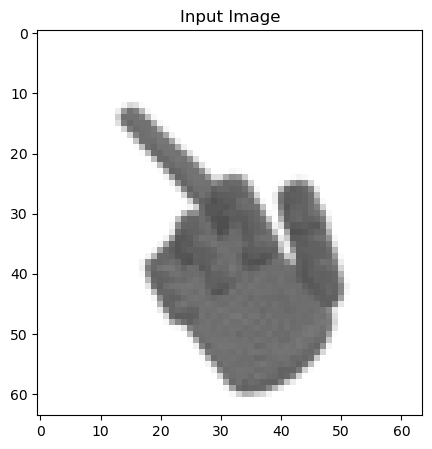

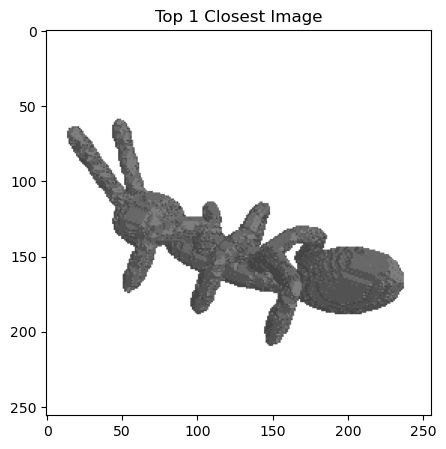

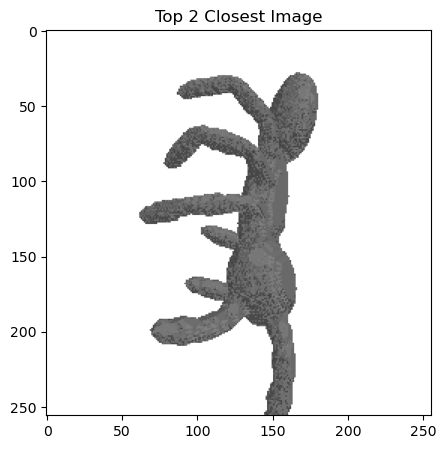

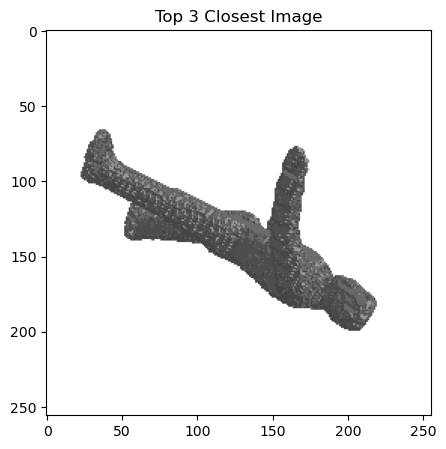

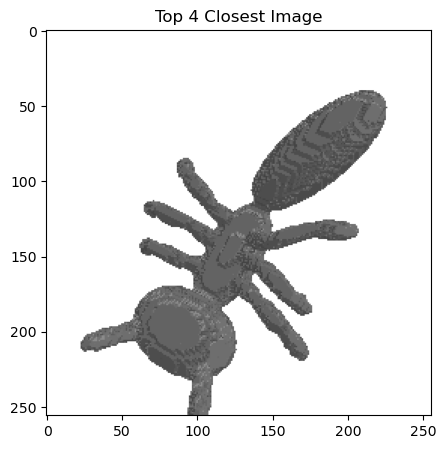

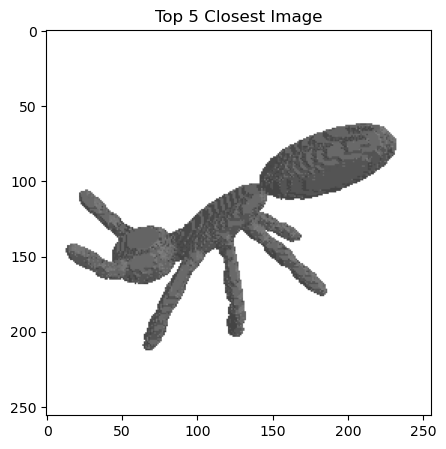

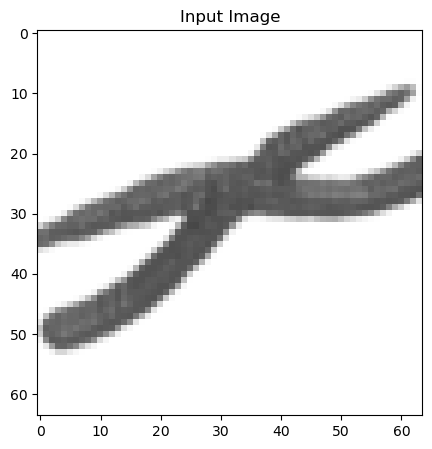

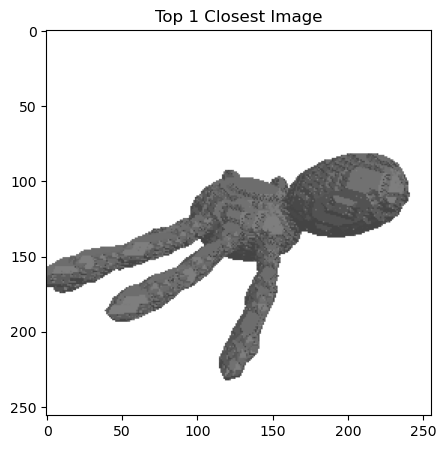

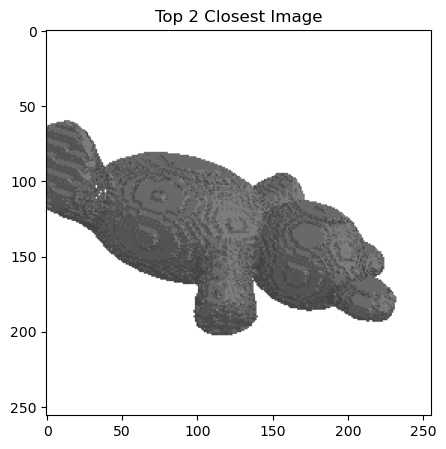

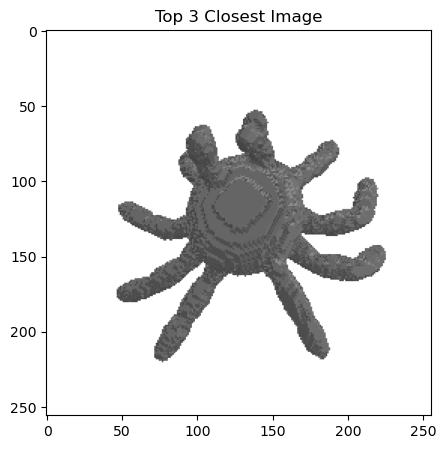

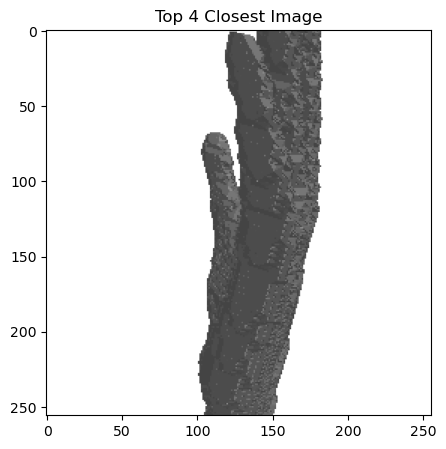

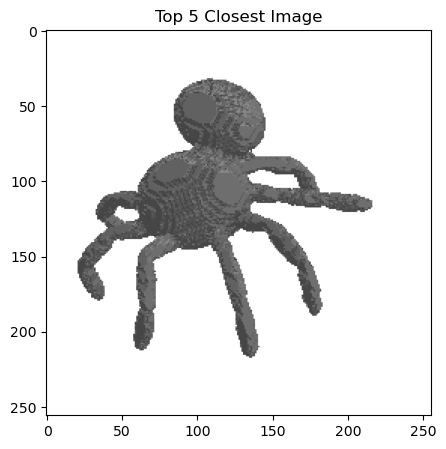

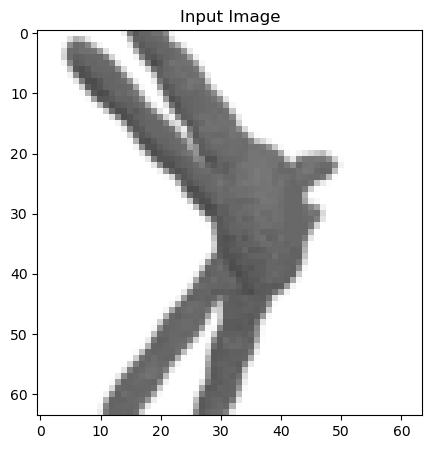

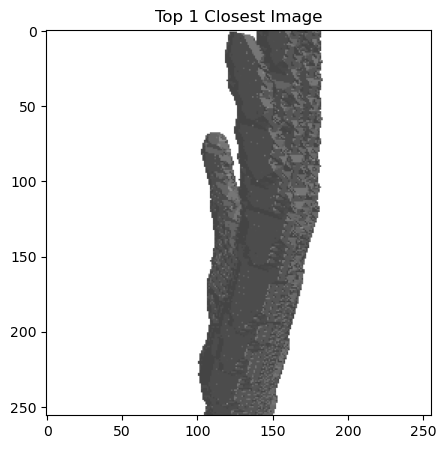

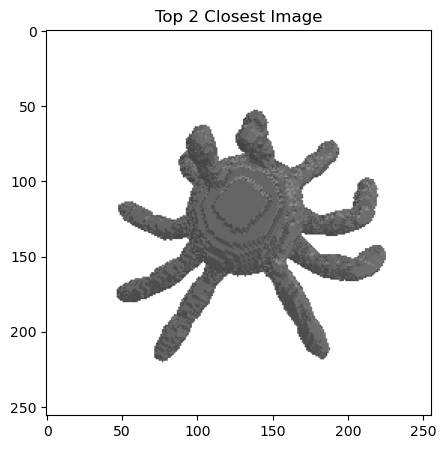

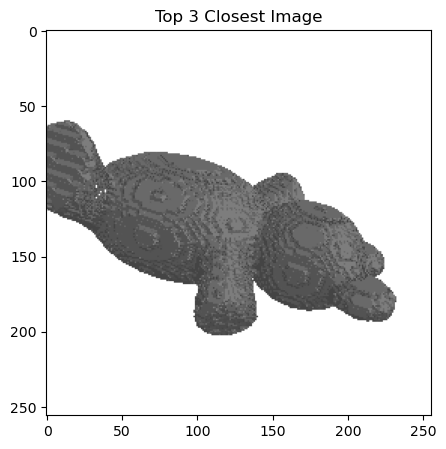

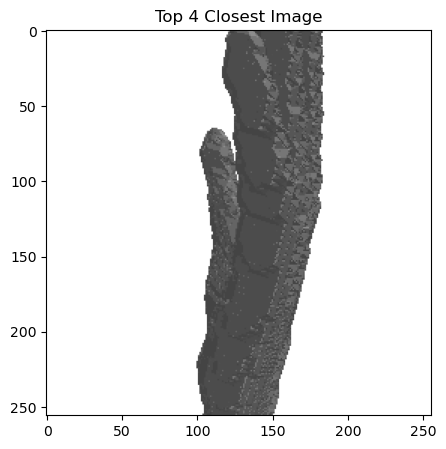

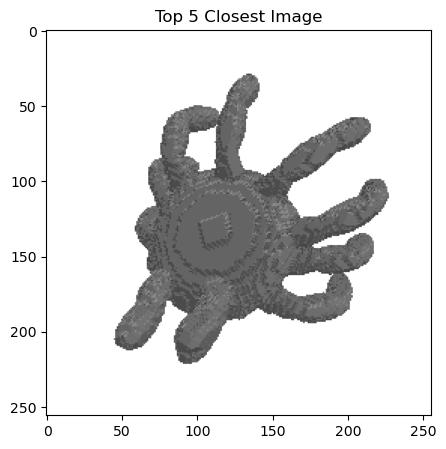

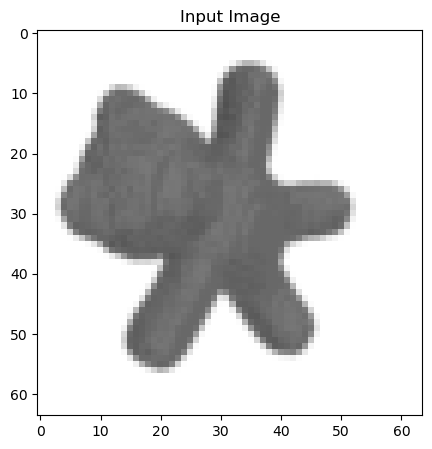

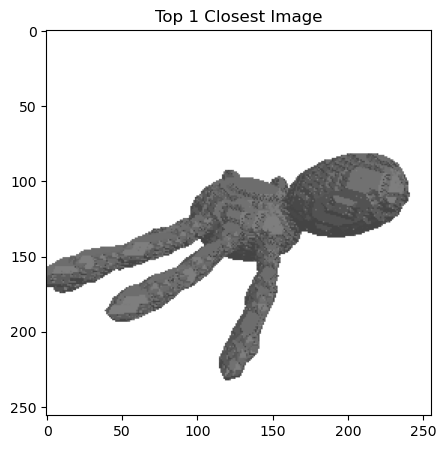

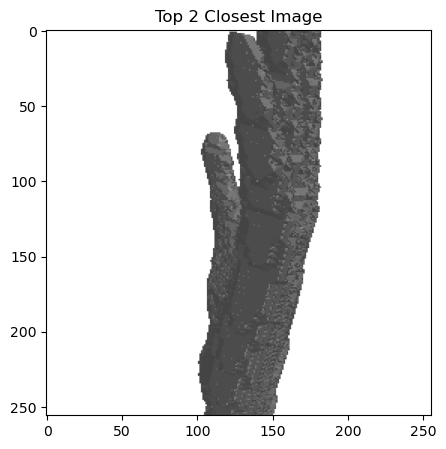

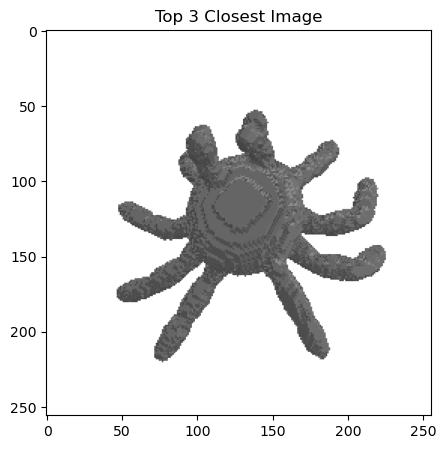

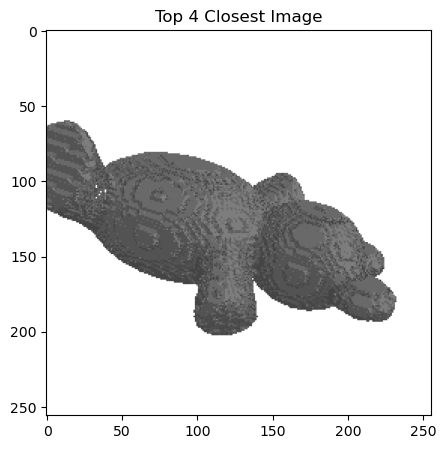

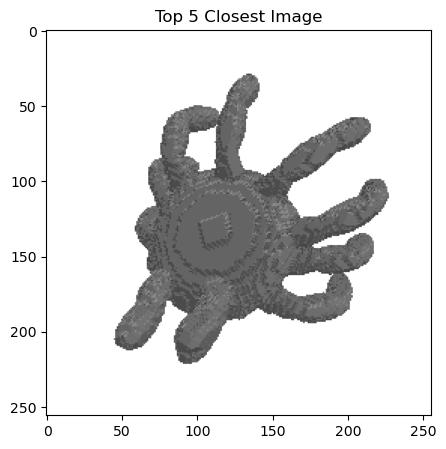

In [63]:
dataiter = iter(validation_loader)
data = next(dataiter)
image, label, value, path = data['image'], data['label'], data['value'], data['path']
with torch.no_grad():
    batch_features = features_extractor(image)
    for i in range(batch_features.size(0)):
        # Plotting the input image
        plt.figure(figsize=(5, 5))
        plt.imshow(image[i].permute(1, 2, 0))  # Adjust the permute depending on your image tensor format
        plt.title("Input Image")
        plt.show()

        features = batch_features[i]
        top_n_closest = find_top_n_closest_to_input(features, file_path, n)
        for j in range(n):
            path_to_model = transform_path(top_n_closest[j][0])
            # Plotting the top N closest images
            plt.figure(figsize=(5, 5))
            closest_image = load_image(top_n_closest[j][0])  # Implement this function to load image from path
            plt.imshow(closest_image)  # Adjust as needed
            plt.title(f"Top {j+1} Closest Image")
            plt.show()